# imports

In [1]:
% load_ext autoreload
% autoreload 2


In [2]:
import glob
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import datetime
import src.mex_helper as mex
import folium
from src.utils.map_vis import time_slider_choropleth, geojson_per_row

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import src.utils.gis as gis
from src.features import *

# grid average

In [5]:
def grid_avgerage(tw_avg, t2g):
    # there are grids without any call throughout the observation period
    g_avg = t2g.merge(tw_avg, left_on='gtid', right_index=True, how='left')

    for h in range(24):
        h = str(h)
        g_avg[h] = g_avg[h] * g_avg['weight']

    g_avg = g_avg.drop(['gtid', 'weight'],
                       axis=1).groupby('grid').sum()  # fillna=0 by default

    return g_avg

In [6]:
aver = mex.stat_tw_dow_aver_hr_uniq_user('out+in')
tw_avg_wd = pd.DataFrame(aver['wd']).T
tw_avg_wk = pd.DataFrame(aver['wk']).T

loading cached tw average stats/stat_tw_dow_aver_hr_uniq_user-out+in.pickle


In [7]:
mex_t2g_mpol = mex.tower2grid('metropolitans_16', 1000)
print(
    'number of towers in cities has no call at all during weekday and weekend',
    len(set(mex_t2g_mpol.gtid) - set(tw_avg_wd.index)),
    len(set(mex_t2g_mpol.gtid) - set(tw_avg_wk.index)))

reading existing t2g file: data/mex_tower/mex_t2g_metropolitans_16_1000m.csv
number of towers in cities has no call at all during weekday and weekend 233 234


In [8]:
# g_avg = pd.DataFrame([average number of calls], index=grid, columns='hour')
g_avg_wd_mpol = grid_avgerage(tw_avg_wd, mex_t2g_mpol)
g_avg_wk_mpol = grid_avgerage(tw_avg_wk, mex_t2g_mpol)

In [13]:
%%time
dv_r_mpol = urban_dilatation_index(g_avg_wd_mpol, 'metropolitans_16', 'metropolitan')

reading existing grids
CPU times: user 1min 10s, sys: 13.4 s, total: 1min 23s
Wall time: 1min 23s


In [10]:
import plotly.offline as offline
offline.init_notebook_mode(connected=True)

In [14]:
tmp = dv_r_mpol.drop('dilatation coefficient', axis=1)
offline.iplot({
    'data':[{'x': list(range(24)), 'y': tmp.loc[r].tolist(), 'name': r} for r in tmp.index]
})

Text(0.5,1,'Fig 6b')

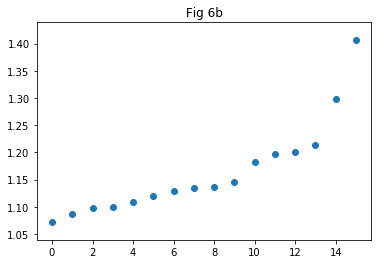

In [15]:
plt.scatter(range(dv_r_mpol.shape[0]),
    dv_r_mpol['dilatation coefficient'].sort_values().values)
plt.title('Fig 6b')

In [17]:
n_hotspot_mpol, hotspot_stats_mpol = hotspot_stats(g_avg_wd_mpol,'metropolitans_16', 'metropolitan')

reading existing grids


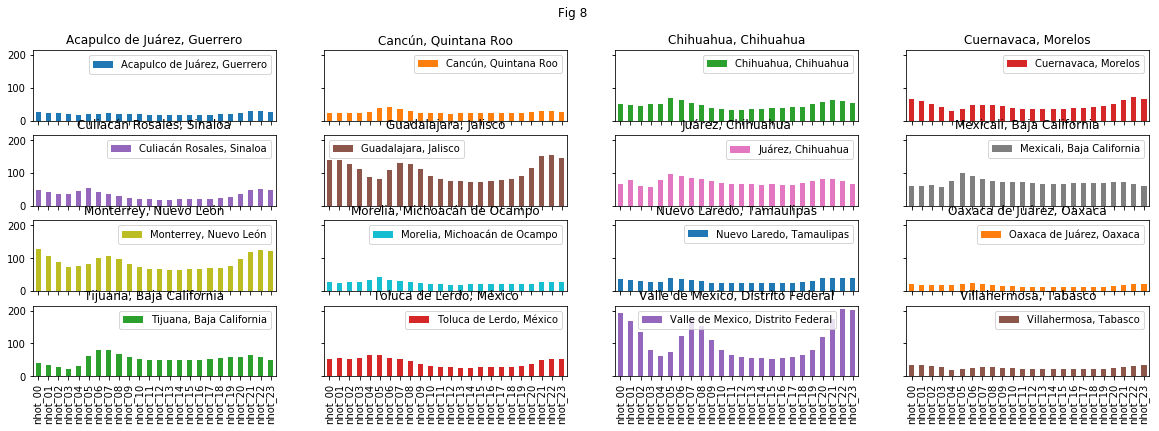

In [18]:
pd.DataFrame(n_hotspot_mpol).T.plot(kind='bar',figsize=(20,6),subplots=True, layout=(4,4),sharey=True, title='Fig 8')
print()

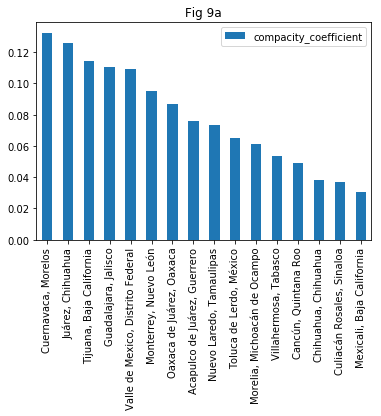

In [19]:
hotspot_stats_mpol = pd.DataFrame(hotspot_stats_mpol)
hotspot_stats_mpol.compacity_coefficient.sort_values(ascending=False).to_frame().plot(kind='bar', title='Fig 9a')

In [20]:
mex_mpol = mex.metropolitans_16()

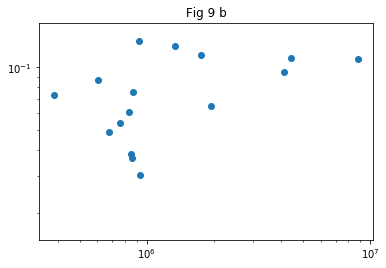

In [21]:
plt.scatter(x=mex_mpol.population.sort_index(), y=hotspot_stats_mpol.compacity_coefficient.sort_index())
plt.title('Fig 9 b')
plt.xscale("log")
plt.yscale("log")

In [22]:
import seaborn as sns

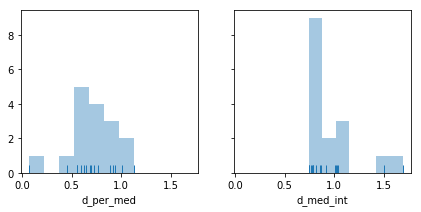

In [23]:
f, axes = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
sns.distplot(hotspot_stats_mpol.d_per_med, kde=False, rug=True,bins=7, ax=axes[0])
sns.distplot(hotspot_stats_mpol.d_med_int, kde=False, rug=True,bins=7, ax=axes[1])